# The main puerpose of this file is to 1. study intergrating Info to AE; 2. implement a U-net to enhance understanding.

In [296]:
import torchvision.datasets as ds
import numpy as np

In [270]:
# firstly, define a auto-encoder: retain most salient information 什么是关键信息？能够还原输入的
import torch.nn as nn
import torch
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        layers = []
        layers.append(nn.Conv2d(kernel_size=3, padding=2, stride=1, in_channels=1, out_channels=1))
        layers.append(nn.Sigmoid())
        layers.append(nn.ConvTranspose2d(kernel_size=3, padding=2, stride=1, in_channels=1, out_channels=1))
        layers.append(nn.Sigmoid()) # dense prediction
        self.layers = layers
        self.model = nn.Sequential(*layers)
        
    def forward(self,x):
        return self.model(x) + x
    
ae = AE()
x = torch.randn(64, 1, 64, 64)
ae(x).shape

torch.Size([64, 1, 64, 64])

## part A: InfoAE
Maximizing Mutual Info between input c and predicted c_hat

In [329]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features=784, out_features=512))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(in_features=512, out_features=256))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(in_features=256, out_features=10))
#         layers.append(nn.Sigmoid()) # 限制了code的范围效果不行，是否和梯度消失有关系？
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x.view(-1, 784))
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features=10, out_features=256))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(in_features=256, out_features=512))
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(in_features=512, out_features=784))
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)
        
    def forward(self, z):
        out = self.model(z)
        return out   

In [298]:
class Dataset():
    def __init__(self, test_val_split=0.5, normalize=True):
        """
        arg:
            test_val_split: the proportion of data_test is used for test data
        """
        self.idx = 0
        self.ds = ds
        self.ratio = test_val_split
        
        self._extract_train_test_data()
        self._test_val_split()
        if normalize:
            self._normalize()
    
    def _extract_train_test_data(self):
        data_train = self.ds.MNIST(root='/Users/ellise/Desktop/datasets/MNIST_data/', train=True, download=False)
        data_test = self.ds.MNIST(root='/Users/ellise/Desktop/datasets/MNIST_data/', train=False, download=False)
        self.X_train, self.y_train = data_train.train_data.float(), data_train.train_labels
        self.X_test, self.y_test = data_test.test_data.float(), data_test.test_labels
        self.num_instances_test = self.X_test.shape[0]
        
    def _test_val_split(self):
        """
        split test and validation set according to split ratio and total_size
        """
        split_idx = self.num_instances_test - int(self.num_instances_test * self.ratio)
        self.X_val, self.y_val = self.X_test[:split_idx], self.y_test[:split_idx]
        self.X_test, self.y_test = self.X_test[split_idx:], self.y_test[split_idx:]
        print("Train set size: {}; Test set size: {}; Validation set size: {}".format(self.X_train.shape[0],\
                                                                                     self.X_test.shape[0],\
                                                                                     self.X_val.shape[0]))
        
    def get_train_batch(self, batch_size):
        idx_start = self.idx
        idx_end = self.idx + batch_size
        self.idx += batch_size

        if(self.idx >= self.X_train.shape[0]):
            self.idx = 0
            idx_list = np.linspace(0,self.X_train.shape[0]-1,self.X_train.shape[0])
            idx_list_shuffle = np.random.shuffle(np.linspace(0,self.X_train.shape[0]-1,self.X_train.shape[0]))

            self.X_train[idx_list] = self.X_train[idx_list_shuffle]
            self.y_train[idx_list] = self.y_train[idx_list_shuffle]
        return (self.X_train[idx_start:idx_end], self.y_train[idx_start:idx_end])
    
    def _normalize(self):
        def squash(X):
            # put data into 0-1
            return (X - torch.min(X)) / (torch.max(X) - torch.min(X))
        self.X_train = squash(self.X_train)
        print()
        self.X_test = squash(self.X_test)
        self.X_val = squash(self.X_val)
        
    def get_test_data(self):
        return (self.X_test, self.y_test)
        
    def get_validation_data(self):
        return (self.X_val, self.y_val)
    
    def get_num_of_instances_in_train(self):
        # used for return how many instances in training set in total
        return self.X_train.shape[0]
    
    def get_test_set_size(self):
        return self.X_test.shape[0]
    
    def get_val_set_size(self):
        return self.X_val.shape[0]

In [330]:
def Train_AE(epochs, batch_size, learning_rate, encoder, decoder, opt, criterion, dataset):
    param = list(encoder.parameters()) + list(decoder.parameters())
    opt = opt(lr=learning_rate, params=param) 
    criterion = criterion()
    
    num = dataset.get_num_of_instances_in_train()
    
    X_test, y_test = dataset.get_test_data()
    
    for e in range(epochs * int(num / batch_size)):
        x_batch, y_batch = dataset.get_train_batch(batch_size=batch_size)
        code = encoder(x_batch)
        x_batch_hat = decoder(code)
        loss = criterion(input=x_batch_hat, target=x_batch.view(-1, 784))
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        # get result every several number of steps
        if e % int(num/batch_size) == 0:
            cur_epoch = int(e / int(num/batch_size)) + 1
            print("Epoch: {}; [Loss] : [{}]".format(cur_epoch, loss))
            
#     X_test_hat = decoder(encoder(X_test, c))
#     loss_test = criterion(input=X_test_hat, target=X_test.view(-1,784))
#     print("Test Loss: {}".format(loss_test))

In [331]:
dataset = Dataset(test_val_split=0.8,normalize=True) # normalize data to 0,1
encoder = Encoder()
decoder = Decoder()
opt = torch.optim.Adam
criterion = nn.MSELoss
Train_AE(epochs=10, batch_size=256, learning_rate=5e-3, encoder=encoder, decoder=decoder,opt=opt, criterion=criterion, dataset=dataset)

Train set size: 60000; Test set size: 8000; Validation set size: 2000

Epoch: 1; [Loss] : [0.23107358813285828]
Epoch: 2; [Loss] : [0.03213575482368469]
Epoch: 3; [Loss] : [0.021273810416460037]
Epoch: 4; [Loss] : [0.01725080981850624]
Epoch: 5; [Loss] : [0.01721201092004776]
Epoch: 6; [Loss] : [0.01468177791684866]
Epoch: 7; [Loss] : [0.015695497393608093]
Epoch: 8; [Loss] : [0.015369824133813381]
Epoch: 9; [Loss] : [0.01426712330430746]
Epoch: 10; [Loss] : [0.014800415374338627]


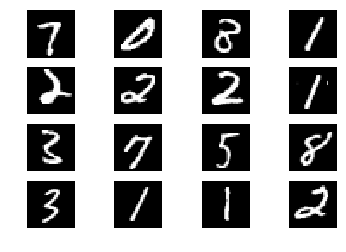

In [332]:
x_batch, y_batch = dataset.get_train_batch(batch_size=256)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_batch[i].detach(), cmap='gray')
    plt.axis('off')

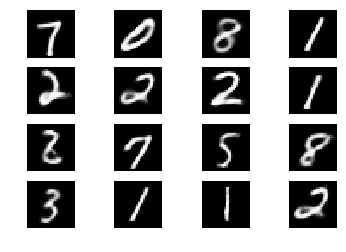

In [351]:
##### import matplotlib.pyplot as plt
# x_batch, _ = dataset.get_train_batch(batch_size=16)
code = encoder(x_batch.view(-1, 784))
# code = torch.zeros_like(code)
# code [:,0] += 0.5
x_reconst = decoder(code)

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_reconst[i].view(28,28).detach(), cmap='gray')
    plt.axis('off')

In [335]:
code

tensor([[-0.3408, -0.6531,  0.4171,  ..., -0.8929, -1.8156, -0.5782],
        [ 0.2632, -2.3161, -4.5071,  ...,  4.1155, -2.0571, -2.1095],
        [ 1.6686, -2.3461, -0.5196,  ...,  0.6723,  0.7480, -0.8037],
        ...,
        [-1.6680, -0.3022,  0.2140,  ...,  1.5278,  1.7897, -0.8048],
        [ 0.7348, -0.7178,  1.0588,  ...,  0.1717, -0.9685, -2.0358],
        [-0.5548, -0.0950,  2.0271,  ...,  0.1891, -0.2435, -0.4719]],
       grad_fn=<AddmmBackward>)

## Train a GAN to generate code representation for original dataset; decode to recover sample in original space

In [339]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features=100, out_features=128))
        layers.append(nn.ReLU(True))
        layers.append(nn.Linear(in_features=128, out_features=10))
#         layers.append(nn.Sigmoid()) # Tanh不太行，可能和Linear而不是Conv有关
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, z):
        return self.model(z)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features=10, out_features=128))
        layers.append(nn.ReLU(True))
        layers.append(nn.Linear(in_features=128, out_features=1))
        layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x.view(x.shape[0], -1))

In [342]:
dataset = Dataset(test_val_split=0.8,normalize=True) # normalize data to 0,1
dataset.X_train = encoder(dataset.X_train).detach()
dataset.X_test = encoder(dataset.X_test).detach()
dataset.X_val = encoder(dataset.X_val).detach()

Train set size: 60000; Test set size: 8000; Validation set size: 2000



In [343]:
G = Generator()
D = Discriminator()
opt_G = torch.optim.Adam(lr=1e-3,params=G.parameters())
opt_D = torch.optim.Adam(lr=1e-3,params=D.parameters())

# dataset = Dataset(0.8, True)
# change training set to [-1,1]
#dataset.X_train = (dataset.X_train - 0.5) * 2
epochs = 50
num = dataset.get_num_of_instances_in_train()
batch_size = 256
for e in range(epochs * int(num / batch_size)):    
    for i in range(1):
        x_real, _ = dataset.get_train_batch(batch_size)
        z = torch.Tensor(np.random.randn(x_real.shape[0], 100))
        x_fake = G(z)

        D_real = D(x_real)
        D_fake = D(x_fake)

        # loss_D = - torch.mean(torch.log(D_real) + torch.log(1-D_fake))
        loss_D = nn.functional.binary_cross_entropy(input=D_real, target=torch.ones_like(D_real))
        loss_D += nn.functional.binary_cross_entropy(input=D_fake, target=torch.zeros_like(D_fake))

        # update D
        loss_D.backward()
        opt_D.step()
        opt_D.zero_grad()
        opt_G.zero_grad()
    
    z = torch.Tensor(np.random.randn(x_real.shape[0], 100))
    x_fake_ = G(z)
    D_fake_ = D(x_fake_)
    #loss_G = - torch.mean(torch.log(D_fake))
    loss_G = nn.functional.binary_cross_entropy(input=D_fake_, target=torch.ones_like(D_fake_))
    
    # update G
    loss_G.backward()
    opt_G.step()
    opt_G.zero_grad()
    opt_D.zero_grad()
    
    if e % int(num/batch_size) == 0:
        print("Epoch:{};Loss_D:{};Loss_G:{}".format(int(e / int(num/batch_size)), loss_D, loss_G))

Epoch:0;Loss_D:1.2914161682128906;Loss_G:0.6359814405441284
Epoch:1;Loss_D:0.8622974753379822;Loss_G:0.9863688349723816
Epoch:2;Loss_D:0.9455296993255615;Loss_G:1.4100452661514282
Epoch:3;Loss_D:1.1038964986801147;Loss_G:1.0091819763183594
Epoch:4;Loss_D:1.6867461204528809;Loss_G:0.7490944266319275
Epoch:5;Loss_D:1.419289469718933;Loss_G:0.8552502989768982
Epoch:6;Loss_D:1.566993236541748;Loss_G:0.9604910016059875
Epoch:7;Loss_D:1.0577930212020874;Loss_G:1.0793362855911255
Epoch:8;Loss_D:1.0112327337265015;Loss_G:1.0307053327560425
Epoch:9;Loss_D:1.3170644044876099;Loss_G:0.976226806640625
Epoch:10;Loss_D:1.3855184316635132;Loss_G:0.8281793594360352
Epoch:11;Loss_D:1.2576253414154053;Loss_G:0.8364502787590027
Epoch:12;Loss_D:1.2532711029052734;Loss_G:0.9973567724227905
Epoch:13;Loss_D:1.3050909042358398;Loss_G:0.9388174414634705
Epoch:14;Loss_D:1.306952714920044;Loss_G:0.7635202407836914
Epoch:15;Loss_D:1.3786497116088867;Loss_G:0.848691463470459
Epoch:16;Loss_D:1.39729905128479;Loss_G

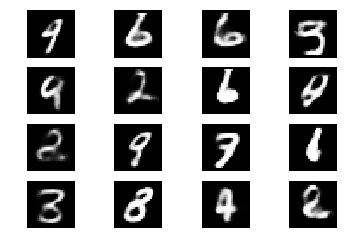

In [350]:
z=torch.Tensor(np.random.randn(x_real.shape[0], 100))
code = G(z)
# code = torch.zeros_like(code)
# code [:,0] += 0.5
x_reconst = decoder(code)

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_reconst[i].view(28,28).detach(), cmap='gray')
    plt.axis('off')

Since reconstruction loss is quite a strong restriction, so this might not work

## part B: U-net 

In [271]:
class U_net_generator(nn.Module):
    def __init__(self, outer_dim, middle_dim, middle=None, outer_most=False):
        super(U_net_generator, self).__init__()
        
        down_layer = [nn.Conv2d(outer_dim, middle_dim, 4,2,1)] # in, out, kernel, stride, padding
        down_layer.append(nn.BatchNorm2d(num_features=middle_dim))
        down_layer.append(nn.ReLU())
        
        up_layer = [nn.ConvTranspose2d(middle_dim, outer_dim, 4,2,1)]
        up_layer.append(nn.BatchNorm2d(num_features=outer_dim))
        if outer_most:
            up_layer.append(nn.Tanh())
        else:
            up_layer.append(nn.ReLU())
            
        if middle == None:
            self.layers = down_layer + up_layer
        else:
            self.layers = down_layer + [middle] + up_layer
            
        self.model = nn.Sequential(*self.layers)
        
    def forward(self, x):
        return self.model(x) + x
    
net = U_net_generator(2,4)
net = U_net_generator(1,2,net)

In [292]:
class middle_layer(nn.Module):
    def __init__(self, outer_dim, middle_dim):
        super(middle_layer, self).__init__()
        down_layer = [nn.Conv2d(outer_dim, middle_dim, 4,2,1)] # in, out, kernel, stride, padding
        down_layer.append(nn.BatchNorm2d(num_features=middle_dim))
        down_layer.append(nn.ReLU())
        
        up_layer = [nn.ConvTranspose2d(middle_dim, outer_dim, 4,2,1)]
        up_layer.append(nn.BatchNorm2d(num_features=outer_dim))
        
        layers = down_layer + up_layer
        self.model = nn.Sequential(*layers)
        
        self.down_layer = down_layer
        
    def forward(self, x):
        global code
        code = nn.Sequential(*self.down_layer)(x)
        return self.model(x) + x

In [293]:
img = torch.randn(2,3,400,600)

In [294]:
code = None
img_dim = 3
num = 2 # latent code res * 2^num = img res
num = num-1 # condiering middle layer dim increase
left = int(img_dim*(2 ** num))
right = int(img_dim*(2 ** num))
net = middle_layer(left, right)
for i in range(num):
    temp = left
    left = int(left / 2)
    right = temp
    net = U_net_generator(left, right, net)

In [295]:
net(img).shape

torch.Size([2, 3, 400, 600])

In [291]:
net

U_net_generator(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): middle_layer(
      (model): Sequential(
        (0): Conv2d(6, 6, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
        (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): ConvTranspose2d(6, 6, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
        (4): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): ConvTranspose2d(6, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
  )
)

In [246]:
code.shape

torch.Size([64, 6, 16, 16])

In [1]:
from dataloader import MNIST_Dataset

dataset = MNIST_Dataset(test_val_split=0.8, normalize=True)

Train set size: 60000; Test set size: 8000; Validation set size: 2000



### part C: Energy Based GAN 

In [52]:
import torch.nn as nn
import torch
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features=100, out_features=128))
        layers.append(nn.ReLU(True))
        layers.append(nn.Linear(in_features=128, out_features=784))
        layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module): # a AE structure
    def __init__(self):
        super(Discriminator, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features=784, out_features=128))
        layers.append(nn.ReLU(True))
        layers.append(nn.Linear(in_features=128, out_features=784))
#         layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)
        
    def forward(self,x):
        return self.model(x)

In [100]:
# implementation of PT requires representation
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features=784, out_features=128))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        layers = []
        layers.append(nn.ReLU(True))
        layers.append(nn.Linear(in_features=128, out_features=784))
        self.model = nn.Sequential(*layers)
        
    def forward(self, z):
        return self.model(z)
    

In [153]:
help(torch.nn.functional.normalize)

Help on function normalize in module torch.nn.functional:

normalize(input, p=2, dim=1, eps=1e-12, out=None)
    Performs :math:`L_p` normalization of inputs over specified dimension.
    
    For a tensor :attr:`input` of sizes :math:`(n_0, ..., n_{dim}, ..., n_k)`, each
    :math:`n_{dim}` -element vector :math:`v` along dimension :attr:`dim` is transformed as
    
    .. math::
        v = \frac{v}{\max(\lVert v \rVert_p, \epsilon)}.
    
    With the default arguments it uses the Euclidean norm over vectors along dimension :math:`1` for normalization.
    
    Args:
        input: input tensor of any shape
        p (float): the exponent value in the norm formulation. Default: 2
        dim (int): the dimension to reduce. Default: 1
        eps (float): small value to avoid division by zero. Default: 1e-12
        out (Tensor, optional): the output tensor. If :attr:`out` is used, this
                                operation won't be differentiable.



$v = \frac{v}{\max(\lVert v \rVert_p, \epsilon)}$

In [152]:
a = torch.randn(3,3)
a = torch.tril(a, -1)
print(a)

tensor([[ 0.0000,  0.0000,  0.0000],
        [ 0.0399,  0.0000,  0.0000],
        [-1.3614,  0.0908,  0.0000]])


In [236]:
repelling_regularizer(code, code)

tensor(1.)

In [232]:
# representation level
# 这个loss目前效果并不是非常好（目的是使得生成的图片更多样），可能原因是训练不够
import torch.nn.functional as F
def repelling_regularizer(s1, s2):
        """Calculate Pulling-away Term(PT)."""

        n = s1.size(0)
        #先逐项normalize
        s1 = F.normalize(s1, p=2, dim=1)
        s2 = F.normalize(s2, p=2, dim=1)
        #BxBxD，两个B所含不同
        S1 = s1.unsqueeze(1).repeat(1, s2.size(0), 1)
        S2 = s2.unsqueeze(0).repeat(s1.size(0), 1, 1)
        #逐项相乘
        f_PT = S1.mul(S2).sum(-1).pow(2)
        f_PT = torch.tril(f_PT, -1).sum().mul(2).div((n*(n-1)))

        #f_PT = (S1.mul(S2).sum(-1).pow(2).sum(-1)-1).sum(-1).div(n*(n-1))
        return f_PT

In [118]:
G = Generator()
enc = Encoder()
dec = Decoder()
opt_G = torch.optim.Adam(lr=1e-3,params=G.parameters())
opt_D = torch.optim.Adam(lr=1e-3,params=list(enc.parameters()) + list(dec.parameters()))

dataset = MNIST_Dataset(0.8, True)
# change training set to [-1,1]
#dataset.X_train = (dataset.X_train - 0.5) * 2
epochs = 10
num = dataset.get_num_of_instances_in_train()
batch_size = 256
m = 5
for e in range(epochs * int(num / batch_size)):    
    for i in range(3):
        x_real, _ = dataset.get_train_batch(batch_size)
        x_real = x_real.view(-1, 784)
        size_of_batch = x_real.shape[0]
        z = torch.Tensor(np.random.randn(x_real.shape[0], 100))
        x_fake = G(z)

        x_reconst_real = dec(enc(x_real))
        x_reconst_fake = dec(enc(x_fake))
        D_real = torch.mean((x_real - x_reconst_real) ** 2, 1)
        D_fake = torch.mean((x_fake - x_reconst_fake) ** 2, 1)
        
        loss_D_ = torch.clamp_min((m - D_fake), 0)
        loss_D = D_real + loss_D_
        loss_D = torch.mean(loss_D)

        # update D
        loss_D.backward()
        opt_D.step()
        opt_D.zero_grad()
        opt_G.zero_grad()
    
    z = torch.Tensor(np.random.randn(x_real.shape[0], 100))
    x_fake_ = G(z)
    h = enc(x_fake_)
    x_reconst_fake_ = dec(h)
    D_fake_ = torch.mean((x_fake_ - x_reconst_fake_) ** 2, 1)
    
    loss_pt = repelling_regularizer(h, h)
    
    loss_G = D_fake_ + loss_pt
    loss_G = torch.mean(loss_G)
    
    # update G
    loss_G.backward()
    opt_G.step()
    opt_G.zero_grad()
    opt_D.zero_grad()
    
    if e % int(num/batch_size) == 0:
        print("Epoch:{};Loss_D:{};Loss_G:{}".format(int(e / int(num/batch_size)), loss_D, loss_G))

Train set size: 60000; Test set size: 8000; Validation set size: 2000

Epoch:0;Loss_D:4.651970863342285;Loss_G:1.6763615608215332
Epoch:1;Loss_D:0.7047917246818542;Loss_G:37.07980728149414
Epoch:2;Loss_D:0.11692502349615097;Loss_G:7.559729099273682
Epoch:3;Loss_D:0.05962752550840378;Loss_G:8.211380004882812
Epoch:4;Loss_D:0.22650030255317688;Loss_G:9.545670509338379
Epoch:5;Loss_D:0.07189350575208664;Loss_G:10.572052955627441
Epoch:6;Loss_D:0.39395660161972046;Loss_G:9.611259460449219
Epoch:7;Loss_D:0.14473100006580353;Loss_G:8.404374122619629
Epoch:8;Loss_D:0.1192273423075676;Loss_G:9.892805099487305
Epoch:9;Loss_D:0.05954381451010704;Loss_G:8.807692527770996


In [65]:
G = Generator()
D = Discriminator()
opt_G = torch.optim.Adam(lr=1e-3,params=G.parameters())
opt_D = torch.optim.Adam(lr=1e-3,params=D.parameters())

dataset = MNIST_Dataset(0.8, True)
# change training set to [-1,1]
#dataset.X_train = (dataset.X_train - 0.5) * 2
epochs = 50
num = dataset.get_num_of_instances_in_train()
batch_size = 256
m = 5
for e in range(epochs * int(num / batch_size)):    
    for i in range(3):
        x_real, _ = dataset.get_train_batch(batch_size)
        x_real = x_real.view(-1, 784)
        z = torch.Tensor(np.random.randn(x_real.shape[0], 100))
        x_fake = G(z)

        x_reconst_real = D(x_real)
        x_reconst_fake = D(x_fake)
        D_real = torch.mean((x_real - x_reconst_real) ** 2, 1)
        D_fake = torch.mean((x_fake - x_reconst_fake) ** 2, 1)
        
        loss_D_ = torch.clamp_min((m - D_fake), 0)
        loss_D = D_real + loss_D_
        loss_D = torch.mean(loss_D)

        # update D
        loss_D.backward()
        opt_D.step()
        opt_D.zero_grad()
        opt_G.zero_grad()
    
    z = torch.Tensor(np.random.randn(x_real.shape[0], 100))
    x_fake_ = G(z)
    x_reconst_fake_ = D(x_fake_)
    D_fake_ = torch.mean((x_fake_ - x_reconst_fake_) ** 2, 1)
    
    loss_G = D_fake_
    loss_G = torch.mean(loss_G)
    
    # update G
    loss_G.backward()
    opt_G.step()
    opt_G.zero_grad()
    opt_D.zero_grad()
    
    if e % int(num/batch_size) == 0:
        print("Epoch:{};Loss_D:{};Loss_G:{}".format(int(e / int(num/batch_size)), loss_D, loss_G))

Train set size: 60000; Test set size: 8000; Validation set size: 2000

Epoch:0;Loss_D:4.651451587677002;Loss_G:0.6890887022018433
Epoch:1;Loss_D:0.20721711218357086;Loss_G:6.828254222869873
Epoch:2;Loss_D:0.14980153739452362;Loss_G:15.94062328338623
Epoch:3;Loss_D:0.05133778601884842;Loss_G:9.121138572692871
Epoch:4;Loss_D:0.14838019013404846;Loss_G:7.572526931762695
Epoch:5;Loss_D:0.092549629509449;Loss_G:9.472505569458008
Epoch:6;Loss_D:0.1043667122721672;Loss_G:19.846860885620117
Epoch:7;Loss_D:0.2908119559288025;Loss_G:13.353841781616211
Epoch:8;Loss_D:0.10150217264890671;Loss_G:8.072333335876465
Epoch:9;Loss_D:0.23601719737052917;Loss_G:6.2242279052734375
Epoch:10;Loss_D:0.15371356904506683;Loss_G:7.357212543487549
Epoch:11;Loss_D:0.2047193944454193;Loss_G:7.266393661499023
Epoch:12;Loss_D:0.21556812524795532;Loss_G:8.368830680847168
Epoch:13;Loss_D:0.33321309089660645;Loss_G:7.849333763122559
Epoch:14;Loss_D:0.4021087884902954;Loss_G:7.970800876617432
Epoch:15;Loss_D:0.4933046102

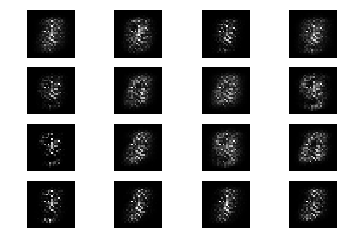

In [121]:
import matplotlib.pyplot as plt
z = torch.Tensor(np.random.randn(x_real.shape[0], 100))
x_fake = G(z).view(x_real.shape[0], 28, 28)
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_fake[i].detach(), cmap='gray')
    plt.axis('off')

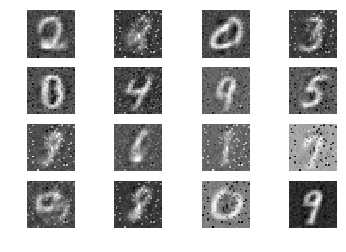

In [122]:
import matplotlib.pyplot as plt
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_reconst_real.view(-1, 28, 28)[i].detach(), cmap='gray')
    plt.axis('off')

In [32]:
# 去掉sigmoid试一下
a = torch.randn(1)
print(torch.relu(a))
print(torch.clamp_min(a, min=0))

tensor([1.8962])
tensor([1.8962])


# Transfering MNIST from noise domain to clean domain

In [154]:
from dataloader import MNIST_Dataset

dataset = MNIST_Dataset(test_val_split=0.8, normalize=True)

Train set size: 60000; Test set size: 8000; Validation set size: 2000



In [163]:
# define a U-net which takes noise images as inputs
# return clean images to discriminator

class U_net_generator(nn.Module):
    def __init__(self, outer_dim, middle_dim, middle=None, outer_most=False):
        super(U_net_generator, self).__init__()
        
        down_layer = [nn.Conv2d(outer_dim, middle_dim, 4,2,1)] # in, out, kernel, stride, padding
        down_layer.append(nn.BatchNorm2d(num_features=middle_dim))
        down_layer.append(nn.ReLU())
        
        up_layer = [nn.ConvTranspose2d(middle_dim, outer_dim, 4,2,1)]
        up_layer.append(nn.BatchNorm2d(num_features=outer_dim))
        if outer_most:
            up_layer.append(nn.Sigmoid())
        else:
            up_layer.append(nn.ReLU())
            
        if middle == None:
            self.layers = down_layer + up_layer
        else:
            self.layers = down_layer + [middle] + up_layer
            
        self.model = nn.Sequential(*self.layers)
        
    def forward(self, x):
        return self.model(x) + x
    
class Discriminator(nn.Module): # 可以试一下energy structure
    def __init__(self):
        super(Discriminator, self).__init__()
        layers = []
        layers.append(nn.Linear(in_features=784, out_features=128))
        layers.append(nn.ReLU(True))
        layers.append(nn.Linear(in_features=128, out_features=1))
        layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)
        
    def forward(self,x):
        return self.model(x.view(-1, 784))
    

In [169]:
G = U_net_generator(8,16)
G = U_net_generator(1,8,G)
D = Discriminator()
opt_G = torch.optim.Adam(lr=1e-3,params=G.parameters())
opt_D = torch.optim.Adam(lr=1e-3,params=D.parameters())

dataset = MNIST_Dataset(0.8, True)
# change training set to [-1,1]
#dataset.X_train = (dataset.X_train - 0.5) * 2
epochs = 10
num = dataset.get_num_of_instances_in_train()
batch_size = 256
for e in range(epochs * int(num / batch_size)):    
    for i in range(1):
        x_real, _ = dataset.get_train_batch(batch_size)
        x_fake = G(torch.unsqueeze(x_real,1))

        D_real = D(x_real)
        D_fake = D(x_fake)
        loss_D = torch.log(D_real) + torch.log(1-D_fake)
        loss_D = torch.mean(loss_D)

        # update D
        loss_D.backward()
        opt_D.step()
        opt_D.zero_grad()
    
    x_fake = G(torch.unsqueeze(x_real,1))
    D_fake = D(x_fake)
    
    loss_G = -torch.log(D_fake)
    loss_G = torch.mean(loss_G)
    
    # update G
    loss_G.backward()
    opt_G.step()
    opt_G.zero_grad()
    
    if e % int(num/batch_size) == 0:
        print("Epoch:{};Loss_D:{};Loss_G:{}".format(int(e / int(num/batch_size)), loss_D, loss_G))

Train set size: 60000; Test set size: 8000; Validation set size: 2000

Epoch:0;Loss_D:-1.379427194595337;Loss_G:0.6243404150009155
Epoch:1;Loss_D:-88.37625885009766;Loss_G:88.37625885009766


KeyboardInterrupt: 

In [ ]:
# 若AE(G(z)) 和 AE(x_real)一样， 而AE重建x_real perfectly, 则G（z）和x_real是否一样？不一样。不可逆
